In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark-nlp") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
    .getOrCreate()

In [2]:
spark

In [3]:
pip install h2o-pysparkling-2.4

     |████████████████████████████████| 116.7 MB 115.2 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 73.4 MB/s eta 0:00:01
  Created wheel for h2o-pysparkling-2.4: filename=h2o_pysparkling_2.4-3.30.0.1.post1-py2.py3-none-any.whl size=116803431 sha256=4d78823b0264f8d7d7898f148a893179f8702051fb13df94a8bfb6a8323108e1
  Stored in directory: /home/hadoop/.cache/pip/wheels/4b/17/0f/b7caafbc97899aca9eff7648851a12d6630070b5e604065d36
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=d380e1cea158971a0a4956d0ebd4b8fd8a61f818fe533e25bd9818cf28ae7167
  Stored in directory: /home/hadoop/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built h2o-pysparkling-2.4 future
Note: you may need to restart the kernel to use updated packages.


In [4]:
import h2o  
from h2o.estimators.word2vec import H2OWord2vecEstimator  
from h2o.estimators.gbm import H2OGradientBoostingEstimator  
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator 
from pysparkling import *  
from nltk.corpus import stopwords  

conf = H2OConf(spark).set('spark.dynamicAllocation.enabled', False) 
hc = H2OContext.getOrCreate(spark, conf)   

Constructor H2OConf(spark) with spark argument is deprecated. Please use just H2OConf(). The argument will be removed in release 3.32.
Method getOrCreate with spark argument is deprecated. Please use either just getOrCreate() or if you need to pass extra H2OConf, use getOrCreate(conf). The spark argument will be removed in release 3.32.


Connecting to H2O server at http://172.31.19.24:54321 ... successful.


H2O_cluster_uptime:,12 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,18 days
H2O_cluster_name:,sparkling-water-hadoop_application_1587503307333_0001
H2O_cluster_total_nodes:,4
H2O_cluster_free_memory:,40.13 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.30.0.1-1-2.4
 * H2O name: hadoop
 * cluster size: 4
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.31.19.24,54321)
  (1,172.31.25.110,54321)
  (2,172.31.25.118,54321)
  (3,172.31.25.242,54321)
  ------------------------

  Open H2O Flow in browser: http://ip-172-31-20-105.ec2.internal:54323 (CMD + click in Mac OSX)

    
 * Yarn App ID of Spark application: application_1587503307333_0001
    


## Data Exploration

In [5]:
reviews = spark.read.parquet("s3://amazon-reviews-pds/parquet/")

In [6]:
# Size of the Review Tables (Row Count)
print("Total Number of Reviews in the Dataset:")
reviews.count()

Total Number of Reviews in the Dataset:


160796570

In [7]:
# Print Schema
print("Dataset Schema (Column Names)")
reviews.columns

Dataset Schema (Column Names)


['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date',
 'year',
 'product_category']

In [8]:
# Take a look at first 10 rows
reviews.head()

Row(marketplace='US', customer_id='15444933', review_id='R1WWG70WK9VUCH', product_id='1848192576', product_parent='835940987', product_title='Standing Qigong for Health and Martial Arts - Zhan Zhuang', star_rating=5, helpful_votes=9, total_votes=10, vine='N', verified_purchase='Y', review_headline='Informative AND interesting!', review_body="After attending a few Qigong classes, I wanted to have a book to read and re-read the instructions so I could practice at home.  I also wanted to gain more of an understanding of the purpose and benefit of the movements in order to practice them with a more focused purpose.<br /><br />The book exceeded my expectations.  The explanations are very clear and are paired with photos showing the correct form.  The book itself is more than just the Qigong, it's a very interesting read.  I read the whole book in two days and will read it again. I rarely read books twice!  The book has provided the information and additional instruction that I was looking f

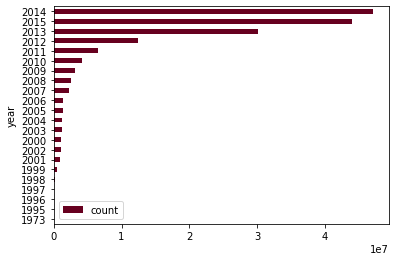

In [9]:
# Plot of # of Reviews by Year
%matplotlib inline
import matplotlib.pyplot as plt

reviews.createOrReplaceTempView("reviews")
year = spark.sql("SELECT year,count(*) AS count FROM reviews GROUP BY year ORDER BY count(*) ASC")
year_p = year.toPandas()
year_p.plot(kind='barh',x='year',y='count',colormap='RdBu')

([<matplotlib.patches.Wedge at 0x7ff153f93a50>,
 [Text(-0.15006395858209792, 1.0897159301096182, 'PC'),
  Text(-0.39684995714878935, 1.0259191544712498, 'Kitchen'),
  Text(-0.6085076764467527, 0.9163615049233431, 'Home'),
  Text(-0.8509339898306464, 0.6970734143193941, 'Wireless'),
  Text(-0.9647080953487388, 0.5285246359145513, 'Video'),
  Text(-0.970663909840408, 0.5175051440646098, 'Digital_Video_Games'),
  Text(-1.0191115354666345, 0.4140189346863726, 'Digital_Video_Download'),
  Text(-1.0577721067781514, 0.30185786410513016, 'Luggage'),
  Text(-1.0829672101277656, 0.1928264032441716, 'Sports'),
  Text(-1.0988404819022348, 0.050493517731133745, 'Video_Games'),
  Text(-1.0999599710118677, 0.009384144690451214, 'Mobile_Electronics'),
  Text(-1.099964326985218, -0.008858857711723185, 'Home_Entertainment'),
  Text(-1.0143065788242838, -0.42565498253136563, 'Digital_Ebook_Purchase'),
  Text(-0.7611836267505354, -0.7941029444391337, 'Baby'),
  Text(-0.6340745404221574, -0.898860098785361

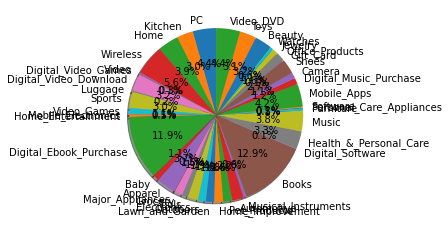

In [10]:
# Plot of distribution of product categories
product = spark.sql("SELECT product_category,count(*) AS count FROM reviews GROUP BY product_category")
product_p = product.toPandas()
product_category = product_p['product_category']
sizes = product_p['count']

plt.pie(sizes,labels=product_category, autopct='%1.1f%%',shadow=True, startangle=90)

([<matplotlib.patches.Wedge at 0x7ff1531e02d0>,
 [Text(-0.2694743214012183, 1.066481875188394, '1'),
  Text(-0.7474214394131705, 0.8070695087200015, '3'),
  Text(-0.2162598132700551, -1.07853219384699, '5'),
  Text(0.8248757726255773, 0.7277224469090926, '4'),
  Text(0.1648739232195761, 1.087573716785297, '2')],
 [Text(-0.1469859934915736, 0.5817173864663967, '7.9%'),
  Text(-0.407684421498093, 0.44021973202909165, '8.0%'),
  Text(-0.11795989814730276, -0.5882902875529036, '61.9%'),
  Text(0.44993223961395123, 0.3969395164958686, '17.4%'),
  Text(0.08993123084704151, 0.5932220273374347, '4.8%')])

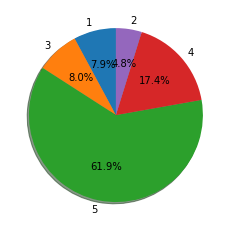

In [11]:
#Counts of different stars
rating = spark.sql("SELECT star_rating,count(*) AS count FROM reviews GROUP BY star_rating")
rating_p = rating.toPandas()

star_rating = rating_p['star_rating']
sizes = rating_p['count']

plt.pie(sizes,labels=star_rating, autopct='%1.1f%%',shadow=True, startangle=90)

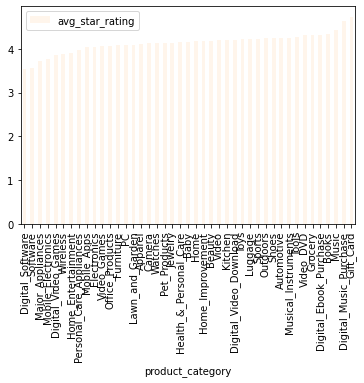

In [12]:
# Avg star_rating by Product_Category
rating2 = spark.sql("SELECT product_category, mean(star_rating) AS avg_star_rating FROM reviews GROUP BY product_category \
ORDER BY mean(star_rating) ASC ")
rating2_p = rating2.toPandas()

rating2_p.plot(kind='bar',x='product_category',y='avg_star_rating',colormap='Oranges')